In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
import matplotlib.ticker as ticker
# import timedelta
import datetime
from datetime import timedelta

In [3]:
def read_hh_dataset(dataset_path):

    ann_dataset = pd.read_csv(dataset_path, sep='\t')

    raw_columns = ['Date & Time', 'Sensor ID', 'Room-level', 'Sensor location', 'Message', 'Sensor Type']
    ann_columns = raw_columns + ['Activity']

    ann_dataset.columns = ann_columns
    # ann_dataset['Activity'] = ann_dataset['Activity'].apply(lambda x: activity_mapping[x] if x in activity_mapping else x)

    ann_dataset['Date & Time'] = pd.to_datetime(ann_dataset['Date & Time'], format='%Y-%m-%d %H:%M:%S')
    start_time, end_time = ann_dataset['Date & Time'].min(), ann_dataset['Date & Time'].max()
    timeframed_dataset = ann_dataset.set_index(['Date & Time'])

    activity2id = {}
    count = 0
    for act in ann_dataset['Activity'].unique():
        if act != 'Other_Activity':
            activity2id[act] = count
            count += 1
    activity2id['Other_Activity'] = count
    
    return timeframed_dataset, start_time, end_time, activity2id

In [3]:
activity_mapping = {"hh102":{
        "Eat": "Other_Activity",
        "Cook_Breakfast": "Cook",
        "Cook_Lunch": "Cook",
        "Cook_Dinner": "Cook",
        "Eat_Breakfast": "Eat",
        "Eat_Lunch": "Eat",
        "Eat_Dinner": "Eat",
        "Wash_Breakfast_Dishes": "Wash_Dishes",
        "Wash_Lunch_Dishes": "Wash_Dishes",
        "Wash_Dinner_Dishes": "Wash_Dishes",
        "Groom" : "Bathe",
        "Work_At_Table": "Work"
    }
}

### Activity plotting without merging

In [14]:
# load hh102 data
df, start, end, a2id = read_hh_dataset('../hh_dataset/hh102/hh102.ann.txt')
df = df[df['Activity'] != 'Other_Activity']
anchor_labels = ['Bathe', 'Enter_home', 'Wash_Dishes', 'Relax', 'Work', 'Sleep', 'Leave_home', 'Cook', 'Eat', 'Personal_Hygiene', 'Bed_Toilet_Transition']

In [15]:
# Get only from 2011-08-01 to 2011-08-31
sub_df = df.loc['2011-07-31':'2011-08-03']
# sub_df = df
sub_df['time'] = pd.to_datetime(sub_df.index).time

sub_df = sub_df[sub_df.apply(lambda x : x['Activity'] in anchor_labels + list(activity_mapping['hh102'].keys()), axis=1)]

# divide the index by 10 mins and round to the nearest integer
sub_df['time_seg'] = sub_df['time'].apply(lambda x: round((x.hour * 60 + x.minute )/ 5) * 5)
# map the time segment back to the time
# sub_df['time_seg'] = sub_df['time_seg'].apply(lambda x: pd.to_datetime('00:00:00') + pd.to_timedelta(x, unit='m'))

# count the number of activities in each time segment
sub_df = sub_df.groupby(['time_seg', 'Activity']).size().reset_index(name='count')

# get the number of occurences of each activity
print(sub_df['Activity'].value_counts())

# multipy the count inversely proportional to the number of occurences
sub_df['count'] = sub_df.apply(lambda x: x['count'] / sub_df['Activity'].value_counts()[x['Activity']], axis=1)

# keep the largest activity in each time segment
sub_df = sub_df.groupby('time_seg').apply(lambda x: x[x['count'] == x['count'].max()]).reset_index(drop=True)
sub_df

/home/simon/miniconda3/envs/casas/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Sleep                    114
Relax                     62
Personal_Hygiene          48
Work_At_Table             32
Cook_Dinner               22
Groom                     21
Work                      16
Wash_Dinner_Dishes        13
Eat_Dinner                12
Cook_Breakfast            10
Eat_Breakfast              8
Bathe                      7
Eat_Lunch                  7
Cook_Lunch                 6
Bed_Toilet_Transition      5
Wash_Dishes                5
Wash_Breakfast_Dishes      4
Eat                        3
Cook                       2
Wash_Lunch_Dishes          2
Name: Activity, dtype: int64


,time_seg,Activity,count
0,10,Sleep,0.008772
1,20,Sleep,0.008772
2,25,Sleep,0.026316
3,30,Sleep,0.078947
4,35,Sleep,0.096491
...,...,...,...
226,1415,Sleep,0.026316
227,1420,Sleep,0.061404
228,1425,Sleep,0.026316
229,1430,Sleep,0.008772


[-200.    0.  200.  400.  600.  800. 1000. 1200. 1400. 1600.]


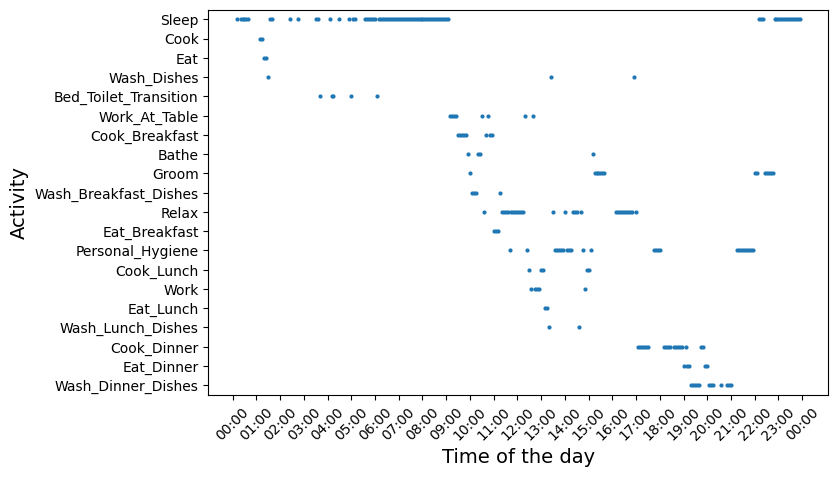

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))
g = sns.stripplot(data=sub_df, x="time_seg", y="Activity", jitter=False, size=3, alpha=1.0, linewidth=0, ax=ax)

# set x axis ticks only show the hour and minute
# ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: pd.to_datetime(x).strftime('%H:%M')))
# xlabels = ['{:,.2f}'.format(x) + 'K' for x in g.get_xticks()/1000]
print(g.get_xticks())
# change the xticks to 100 interval
g.set_xticks(np.arange(0, 1441, 60))
# change the xtick labels to the time, with hour and minute
g.set_xticklabels([(pd.to_datetime('00:00:00') + pd.to_timedelta(x, unit='m')).strftime('%H:%M') for x in np.arange(0, 1441, 60)], rotation=45)

# only show even time
# g.set_xticks(np.arange(0, 1441, 120))

# # set the x-axis label
ax.set_xlabel('Time of the day', fontsize=14)
# set the y-axis label
ax.set_ylabel('Activity', fontsize=14)
# set the title
# ax.set_title('HH102 Activity ', fontsize=16)
# show the plot
plt.show()

### Stripplot with merging

In [144]:
# Apply the same to mapped activities dataset
# load hh102 data
df, start, end, a2id = read_hh_dataset('../hh_dataset/hh102/hh102.ann.txt')
df = df[df['Activity'] != 'Other_Activity']
anchor_labels = ['Bathe', 'Enter_home', 'Wash_Dishes', 'Relax', 'Work', 'Sleep', 'Leave_home', 'Cook', 'Eat', 'Personal_Hygiene', 'Bed_Toilet_Transition']

# map the activities
df['Activity'] = df['Activity'].apply(lambda x: activity_mapping['hh102'][x] if x in activity_mapping['hh102'] else x)

# Get only from 2011-08-01 to 2011-08-31
sub_df = df.loc['2011-07-31':'2011-08-03']
# sub_df = df
sub_df['time'] = pd.to_datetime(sub_df.index).time

sub_df = sub_df[sub_df.apply(lambda x : x['Activity'] in anchor_labels + list(activity_mapping['hh102'].keys()), axis=1)]

# divide the index by 10 mins and round to the nearest integer
sub_df['time_seg'] = sub_df['time'].apply(lambda x: round((x.hour * 60 + x.minute )/ 5) * 5)
# map the time segment back to the time
# sub_df['time_seg'] = sub_df['time_seg'].apply(lambda x: pd.to_datetime('00:00:00') + pd.to_timedelta(x, unit='m'))

# count the number of activities in each time segment
sub_df = sub_df.groupby(['time_seg', 'Activity']).size().reset_index(name='count')

# get the number of occurences of each activity
print(sub_df['Activity'].value_counts())

# multipy the count inversely proportional to the number of occurences
sub_df['count'] = sub_df.apply(lambda x: x['count'] / sub_df['Activity'].value_counts()[x['Activity']], axis=1)

# keep the largest activity in each time segment
sub_df = sub_df.groupby('time_seg').apply(lambda x: x[x['count'] == x['count'].max()]).reset_index(drop=True)
sub_df

/home/simon/miniconda3/envs/casas/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Sleep                    114
Relax                     62
Personal_Hygiene          48
Work                      41
Cook                      40
Eat                       27
Bathe                     23
Wash_Dishes               22
Bed_Toilet_Transition      5
Name: Activity, dtype: int64


,time_seg,Activity,count
0,10,Sleep,0.008772
1,20,Sleep,0.008772
2,25,Sleep,0.026316
3,30,Sleep,0.078947
4,35,Sleep,0.096491
...,...,...,...
224,1415,Sleep,0.026316
225,1420,Sleep,0.061404
226,1425,Sleep,0.026316
227,1430,Sleep,0.008772


[-200.    0.  200.  400.  600.  800. 1000. 1200. 1400. 1600.]


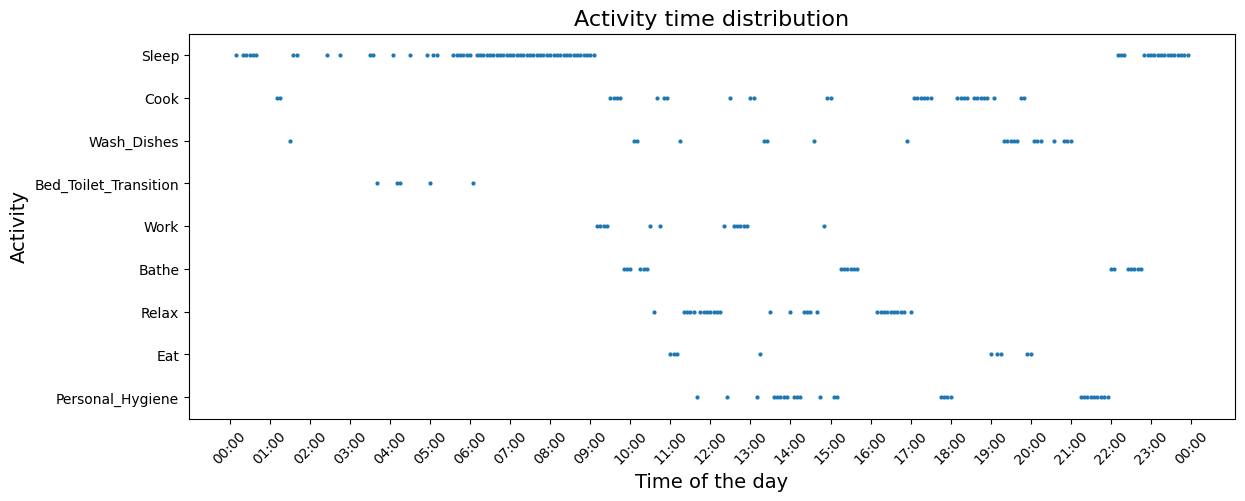

In [145]:
fig, ax = plt.subplots(figsize=(13.5, 5))
g = sns.stripplot(data=sub_df, x="time_seg", y="Activity", jitter=False, size=3, alpha=1.0, linewidth=0, ax=ax)

# set x axis ticks only show the hour and minute
# ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: pd.to_datetime(x).strftime('%H:%M')))
# xlabels = ['{:,.2f}'.format(x) + 'K' for x in g.get_xticks()/1000]
print(g.get_xticks())
# change the xticks to 100 interval
g.set_xticks(np.arange(0, 1441, 60))
# change the xtick labels to the time, with hour and minute
g.set_xticklabels([(pd.to_datetime('00:00:00') + pd.to_timedelta(x, unit='m')).strftime('%H:%M') for x in np.arange(0, 1441, 60)], rotation=45)

# # set the x-axis label
ax.set_xlabel('Time of the day', fontsize=14)
# set the y-axis label
ax.set_ylabel('Activity', fontsize=14)
# set the title
ax.set_title('Activity time distribution', fontsize=16)
# show the plot
plt.show()

### Segmented data visualisation

In [223]:
ftw_predictions = np.load('../ftw_model/result_new1/BiLSTM-(fib_hh105)_1d_cnn_overlook_merged_with_time2vec_10_32/1/predictions.npy', allow_pickle=True)
gold_labels = np.load('../ftw_model/result_new1/BiLSTM-(fib_hh105)_1d_cnn_overlook_merged_with_time2vec_10_32/1/activities.npy', allow_pickle=True)

ftw_predictions = ftw_predictions[:-1]

dummy = np.array([])

# Make the ftw_predictions into a 2D array
for i in range(len(ftw_predictions)):
    dummy = np.append(dummy, ftw_predictions[i])
# reshape it to 2D
ftw_predictions = dummy.reshape(len(ftw_predictions), -1).T
ftw_predictions.shape

(2918, 9)

In [225]:
import json

dataset_activity = np.load('../hh_dataset/hh_npy/fib_hh105_activity.npy', allow_pickle=True)
dataset_act_mapping = json.load(open('../hh_dataset/hh_npy/fib_hh105_mapping.json', 'r'))
activities = list(dataset_act_mapping.keys())[:-1]
pred_start_time = start
pred_start_time

Timestamp('2011-06-15 00:06:33.988964')

In [226]:
# Create a dataframe for the predictions, with the pred_start_time as the start and 10 mins as the interval and the activities as the columns
gold_df = pd.DataFrame(gold_labels, index=pd.date_range(pred_start_time, periods=len(gold_labels), freq='10min'), columns=activities)
df = pd.DataFrame(ftw_predictions, index=pd.date_range(pred_start_time, periods=len(ftw_predictions), freq='10min'), columns=activities)
df.head()

,Sleep,Cook,Work,Personal_Hygiene,Eat,Bathe,Relax,Bed_Toilet_Transition,Wash_Dishes
2011-06-15 00:06:33.988964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-06-15 00:16:33.988964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-06-15 00:26:33.988964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-06-15 00:36:33.988964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-06-15 00:46:33.988964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[-200.    0.  200.  400.  600.  800. 1000. 1200. 1400. 1600.]


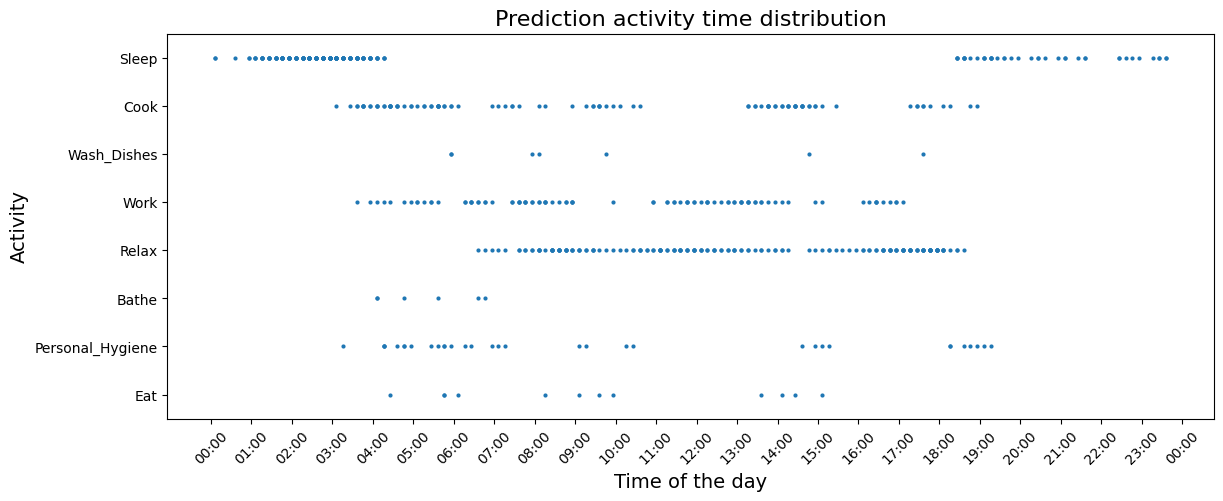

In [230]:
# Get only from 2011-08-01 to 2011-08-31
sub_df = df.loc['2011-06-16':'2011-06-30']
# get the number of occurences of each activity and multiply the count inversely proportional to the number of occurences
sub_df = sub_df.apply(lambda x: x / x.value_counts().max(), axis=0)
# keep the largest activity in each time segment
sub_df = sub_df.apply(lambda x: x[x == x.max()], axis=0)
# For each segment, get the activity with the highest probability
sub_df = sub_df.apply(lambda x: x.idxmax(), axis=1)

# get sub_df back to a dataframe
sub_df = sub_df.to_frame()
# rename the column
sub_df.columns = ['Activity']
# add segment column that normalise the time to 0-1440
sub_df['time_seg'] = sub_df.index.hour * 60 + sub_df.index.minute

fig, ax = plt.subplots(figsize=(13.5, 5))
g = sns.stripplot(data=sub_df, x="time_seg", y="Activity", jitter=False, size=3, alpha=1.0, linewidth=0, ax=ax)

print(g.get_xticks())
# change the xticks to 100 interval
g.set_xticks(np.arange(0, 1441, 60))
# change the xtick labels to the time, with hour and minute
g.set_xticklabels([(pd.to_datetime('00:00:00') + pd.to_timedelta(x, unit='m')).strftime('%H:%M') for x in np.arange(0, 1441, 60)], rotation=45)

# # set the x-axis label
ax.set_xlabel('Time of the day', fontsize=14)
# set the y-axis label
ax.set_ylabel('Activity', fontsize=14)
# set the title
ax.set_title('Prediction activity time distribution', fontsize=16)
# show the plot
plt.show()

[-200.    0.  200.  400.  600.  800. 1000. 1200. 1400. 1600.]


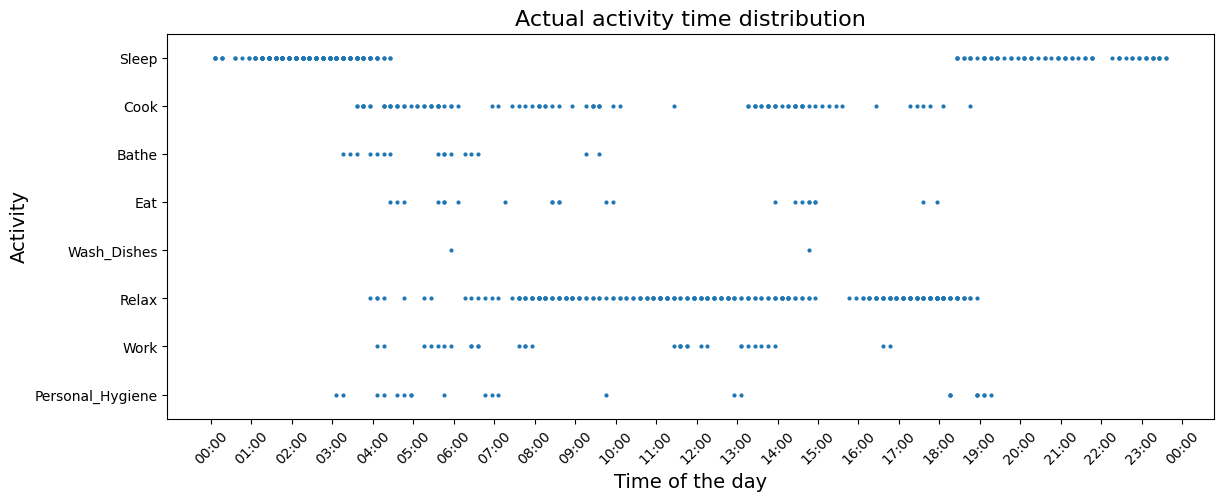

In [231]:
# Get only from 2011-08-01 to 2011-08-31
sub_df = gold_df.loc['2011-06-16':'2011-06-30']
# get the number of occurences of each activity and multiply the count inversely proportional to the number of occurences
sub_df = sub_df.apply(lambda x: x / x.value_counts().max(), axis=0)
# keep the largest activity in each time segment
sub_df = sub_df.apply(lambda x: x[x == x.max()], axis=0)
# For each segment, get the activity with the highest probability
sub_df = sub_df.apply(lambda x: x.idxmax(), axis=1)

# get sub_df back to a dataframe
sub_df = sub_df.to_frame()
# rename the column
sub_df.columns = ['Activity']
# add segment column that normalise the time to 0-1440
sub_df['time_seg'] = sub_df.index.hour * 60 + sub_df.index.minute

fig, ax = plt.subplots(figsize=(13.5, 5))
g = sns.stripplot(data=sub_df, x="time_seg", y="Activity", jitter=False, size=3, alpha=1.0, linewidth=0, ax=ax)

print(g.get_xticks())
# change the xticks to 100 interval
g.set_xticks(np.arange(0, 1441, 60))
# change the xtick labels to the time, with hour and minute
g.set_xticklabels([(pd.to_datetime('00:00:00') + pd.to_timedelta(x, unit='m')).strftime('%H:%M') for x in np.arange(0, 1441, 60)], rotation=45)

# # set the x-axis label
ax.set_xlabel('Time of the day', fontsize=14)
# set the y-axis label
ax.set_ylabel('Activity', fontsize=14)
# set the title
ax.set_title('Actual activity time distribution', fontsize=16)
# show the plot
plt.show()

### Graph plot

In [71]:
### load hh107 data
df, start, end, dictActivities = read_hh_dataset('../hh_dataset/hh107/hh107.ann.txt')

df.head()

,Sensor ID,Room-level,Sensor location,Message,Sensor Type,Activity
Date & Time,,,,,,
2012-07-20 15:30:57.162835,MA019,WorkArea,Office,ON,Control4-MotionArea,Other_Activity
2012-07-20 15:31:00.649418,LS002,Ignore,Ignore,10,Control4-LightSensor,Other_Activity
2012-07-20 15:31:00.673496,M002,WorkArea,Hall,ON,Control4-Motion,Other_Activity
2012-07-20 15:31:01.880285,M002,WorkArea,Hall,OFF,Control4-Motion,Other_Activity
2012-07-20 15:31:02.057242,LS019,Ignore,Ignore,22,Control4-LightSensor,Other_Activity


In [9]:
# filter other activities
df = df[df['Activity'] != 'Other_Activity']
# filter sensor that start with 'T' 
df = df[~df['Sensor'].str.startswith('T')]


,Sensor ID,Room-level,Sensor location,Message,Sensor Type,Activity
Date & Time,,,,,,
2012-07-20 16:05:33.446601,M013,Bedroom,Closet,ON,Control4-Motion,Toilet
2012-07-20 16:05:34.586138,M013,Bedroom,Closet,OFF,Control4-Motion,Toilet
2012-07-20 16:05:35.157337,M013,Bedroom,Closet,ON,Control4-Motion,Toilet
2012-07-20 16:05:37.969739,M013,Bedroom,Closet,OFF,Control4-Motion,Toilet
2012-07-20 16:07:25.660341,M013,Bedroom,Closet,ON,Control4-Motion,Toilet


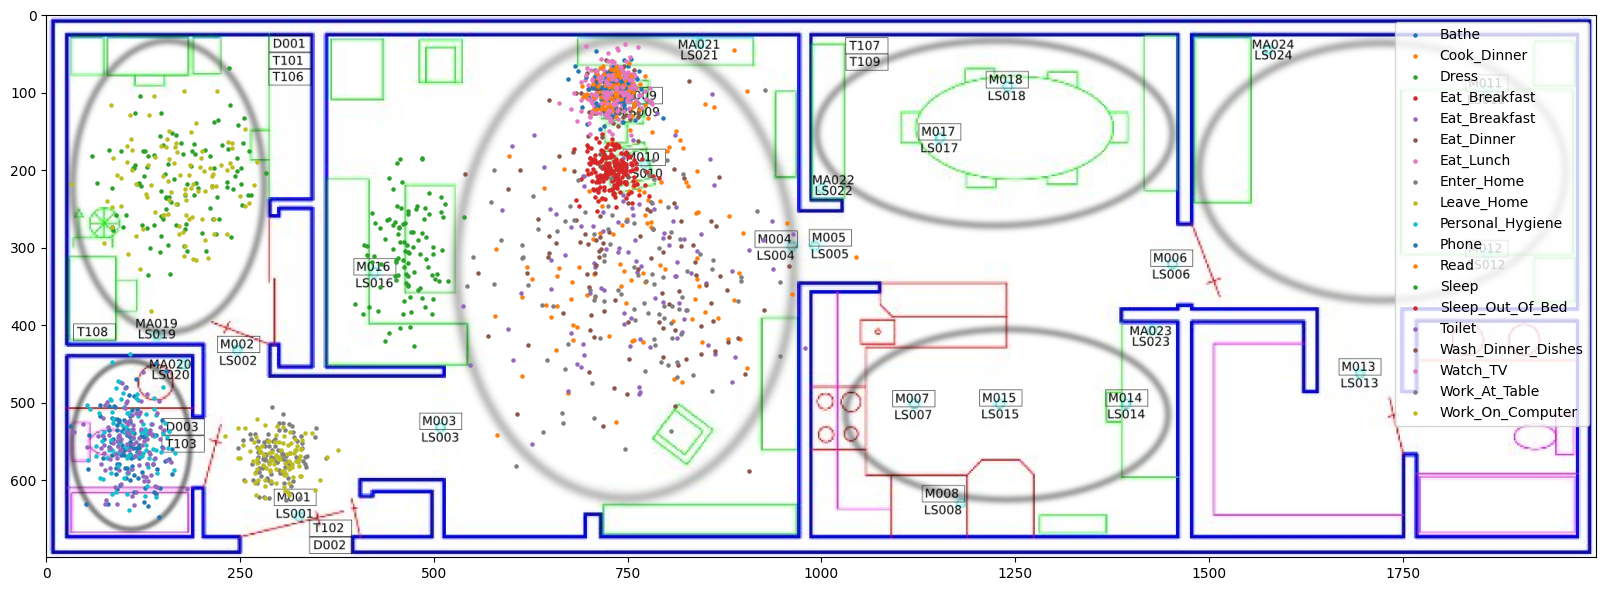

In [10]:
# load the sensor map png
import matplotlib.image as mpimg

img = mpimg.imread('../hh_dataset/hh107/hh107.sensor_map.png')

# display the image
plt.figure(figsize=(20, 10))

df, start, end, dictActivities = read_hh_dataset('../hh_dataset/hh107/hh107.ann.txt')


# plot the scatter plot on top of the image

# (x, y, x_std, y_std)

df = df[df['Activity'] != 'Other_Activity']
# filter sensor that start with 'T' 
df = df[~df['Sensor ID'].str.startswith('T')]

sensor_map = {
    'D001': (300, 35, 5, 5),
    'MA019': (175, 220, 50, 50),
    'M002': (250, 420, 30, 10),
    'MA020': (110, 550, 25, 40),
    'D003' : (225, 565, 8, 20),
    'D002': (320, 650, 35, 8),
    'M001': (300, 570, 25, 25),
    'M003': (500, 520, 35, 20),
    'M016': (460, 310, 30, 50),
    'M009': (730, 100, 20, 20),
    'M010': (730, 200, 20, 20),
    'MA021': (750, 320, 90, 100),
    # 'M004': (),
    # 'M005': (),
    # 'M015': (),
    # 'M007': (),
    # 'M008': (),
    # 'M014': (),
}
# draw 100 scatter points on (300, 35) with gaussian noise
# x = np.random.normal(460, 30, 100)
# y = np.random.normal(310, 50, 100)
# plt.scatter(x, y, c='r', s=5)

# filter sensor that are not in the map
df = df[df['Sensor ID'].isin(sensor_map.keys())]

# filter message that equals to OFF or CLOSE
df = df[~df['Message'].isin(['OFF', 'CLOSE'])]

# keep only the sensor id and the activity
df = df[['Sensor ID', 'Activity']]

# group by sensor id and activity and count the number of occurences
df = df.groupby(['Sensor ID', 'Activity']).size().reset_index(name='count')

# keep the most frequent sensor id for each activity
df = df.groupby('Activity').apply(lambda x: x[x['count'] == x['count'].max()]).reset_index(drop=True)

# iterate through the dataframe and plot the scatter points
for sensor_id, act, count in df.values:
    point = sensor_map[sensor_id]
    x = np.random.normal(point[0], point[2], 100)
    y = np.random.normal(point[1], point[3], 100)
    plt.scatter(x, y, label=act, s=5)

# for sensor_id, act in df.values:
#     point = sensor_map[sensor_id]
#     x = np.random.normal(point[0], point[2], 1)
#     y = np.random.normal(point[1], point[3], 1)
#     plt.scatter(x, y, label=act, s=5)

plt.legend()

plt.imshow(img)